### 3. **Elasticidad del Precio**
**Resumen:** El análisis de elasticidad precio-demanda permite evaluar cómo los cambios en los precios afectan la demanda de aguacates. Comprender la elasticidad puede ayudar a formular estrategias de precios más efectivas.

La fórmula de elasticidad precio-demanda es:

$$
E_d = \frac{\% \text{Cambio en la cantidad demandada}}{\% \text{Cambio en el precio}} = \frac{\Delta Q / Q}{\Delta P / P}
$$

1. **Elasticidad Precio-Demanda por Año:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Volume`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda para cada año.
     - Calcula la variación porcentual de `Total Volume` y `AveragePrice` utilizando `pd.pct_change()`.
     - Utiliza la fórmula de elasticidad para determinar la sensibilidad de la demanda respecto al precio.
     - Presenta los resultados en un gráfico de líneas usando `plt.plot()` para mostrar la elasticidad por año.

2. **Comparación de Elasticidad en Diferentes Mercados:**
   - **Uso de Datos:** Utiliza las columnas `Total Volume` y `AveragePrice`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda en diferentes regiones.
     - Agrupa los datos por `region` y calcula la elasticidad para cada región utilizando `pd.pct_change()`.
     - Presenta un gráfico de barras que muestre la elasticidad por región usando `plt.bar()`.

3. **Elasticidad a Nivel de Tipo de Bolsa:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Bags`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda específica para cada tipo de bolsa.
     - Suma los volúmenes de ventas por tipo de bolsa utilizando `groupby()` y `sum()`.
     - Calcula la elasticidad para cada tipo y presenta los resultados en un gráfico comparativo usando `plt.bar()`.

4. **Análisis de Elasticidad Comparativa entre Orgánicos y Convencionales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Total Volume` y `type`.
   - **Esperado:** Compara la elasticidad de la demanda entre aguacates orgánicos y convencionales.
     - Agrupa los datos por `type` y calcula la elasticidad utilizando `pd.pct_change()`.
     - Presenta un gráfico que muestre la diferencia en elasticidad entre los dos tipos usando `plt.bar()`.

5. **Análisis de la Elasticidad Precios-Ventas:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Volume`.
   - **Esperado:** Examina cómo las variaciones en `AveragePrice` afectan a `Total Volume`.
     - Realiza un análisis de la relación entre estas dos variables calculando la elasticidad.
     - Presenta un gráfico de dispersión que muestre la relación y discute la tendencia observada utilizando `plt.scatter()` y `plt.plot()`.


In [1]:
# Cargar librerias
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
sys.path.append('../../../aguacate-aljoan/')  # Adjust to the path where utils is located
from utils.data import obtener_nuevo_avocado, imputar_fechas

df_orig = imputar_fechas()

#df_orig = pd.read_csv("avocado_with_region_types.csv")

# guardamos el original y trabajamos con una copia
df = df_orig.copy()
# Convierte Date a tipo datetime usando pd.to_datetime().
# Convierte la columna de fecha a un formato adecuado.

df['Date'] = pd.to_datetime(df['Date'])

# Filtrar los datos para 'GreaterRegion' en la columna 'region_type'
df_reduced = df.loc[df['region_type'] == 'GreaterRegion'].copy()
df_cities = df.loc[df['region_type'] == 'City'].copy()
df_regions = df.loc[df['region_type'] == 'Region'].copy()


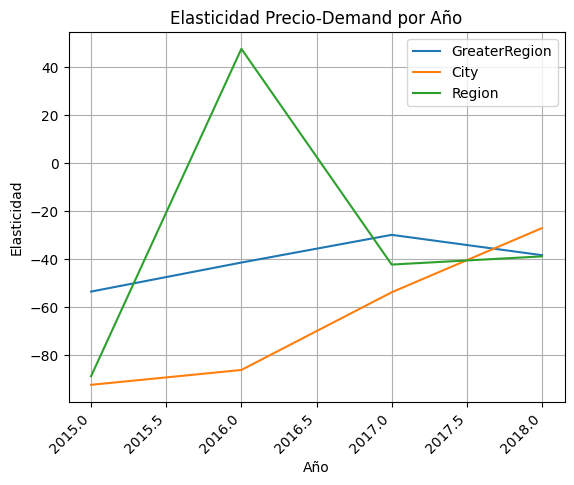

In [2]:
"""
3.1 Elasticidad Precio-Demanda por Año:

Uso de Datos: Usa las columnas AveragePrice y Total Volume.
Esperado: Calcula la elasticidad del precio de la demanda para cada año.
Calcula la variación porcentual de Total Volume y AveragePrice utilizando pd.pct_change().
Utiliza la fórmula de elasticidad para determinar la sensibilidad de la demanda respecto al precio.
Presenta los resultados en un gráfico de líneas usando plt.plot() para mostrar la elasticidad por año.
"""
dfs = [df_reduced, df_cities, df_regions]
labels = ['GreaterRegion', 'City', 'Region']

for df, label in zip(dfs, labels):
    # Calcular variación porcentual
    df['Price_pct_change'] = df['AveragePrice'].pct_change()
    df['Volume_pct_change'] = df['Total Volume'].pct_change()
    
    # Calcular elasticidad y gestionar ceros y bulos
    df['Elasticity'] = df['Volume_pct_change'] / df['Price_pct_change']
    
    # Quitar NaN y valores infinitos
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Quitar NaN de Elasticity
    df.dropna(subset=['Elasticity'], inplace=True)

    # Agrupar por año y calcular media de Elasticity
    elasticity_by_year = df.groupby(df['Date'].dt.to_period('Y'))['Elasticity'].mean().reset_index()
    elasticity_by_year['Year'] = elasticity_by_year['Date'].dt.year

    # Dibujar elasticity
    plt.plot(elasticity_by_year['Year'], elasticity_by_year['Elasticity'], label=label)

# Titulo y etiquetas
plt.xlabel('Año')
plt.ylabel('Elasticidad')
plt.title('Elasticidad Precio-Demand por Año')
plt.xticks(rotation=45, ha='right')  # mejorar legibilidad
plt.legend()
plt.grid(True)
plt.show()

print("===============================================================================================")
print("===============================================================================================")

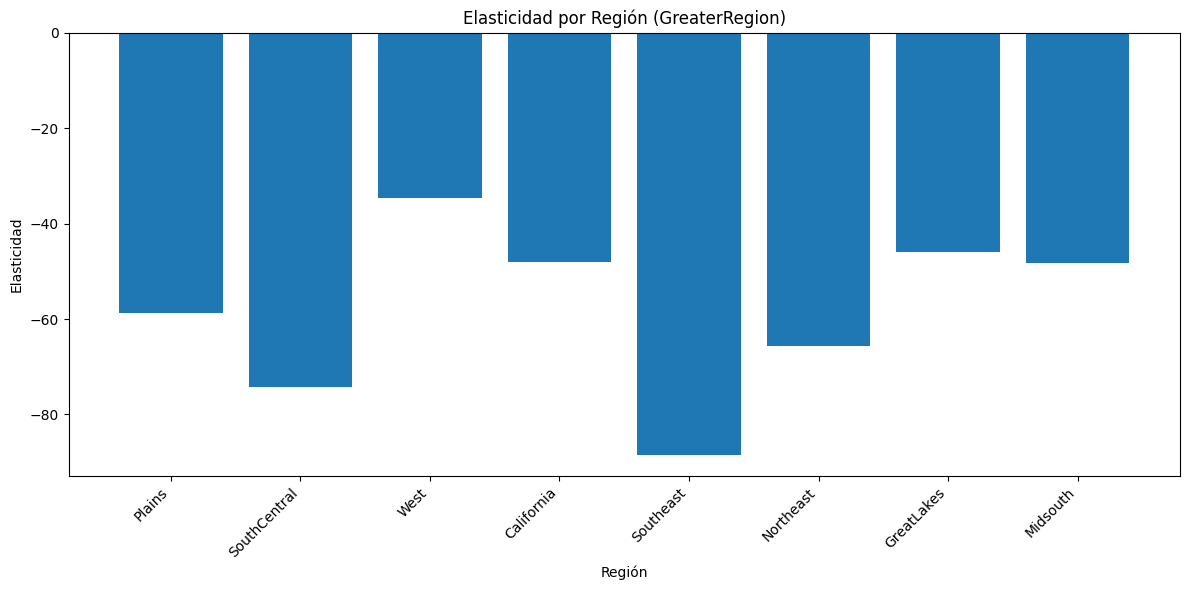

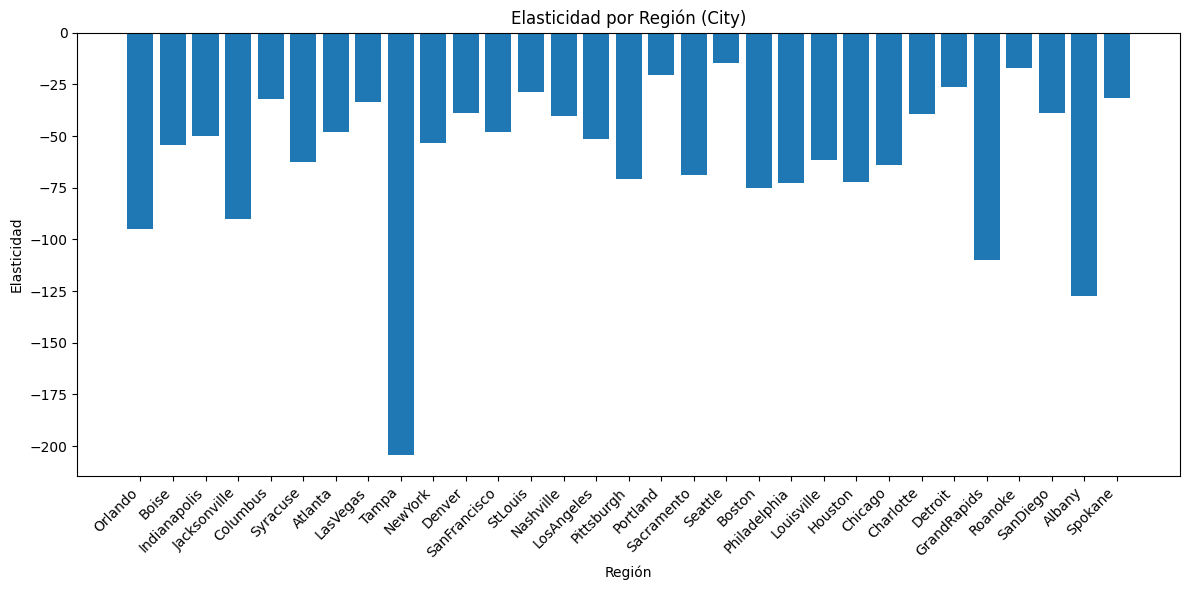

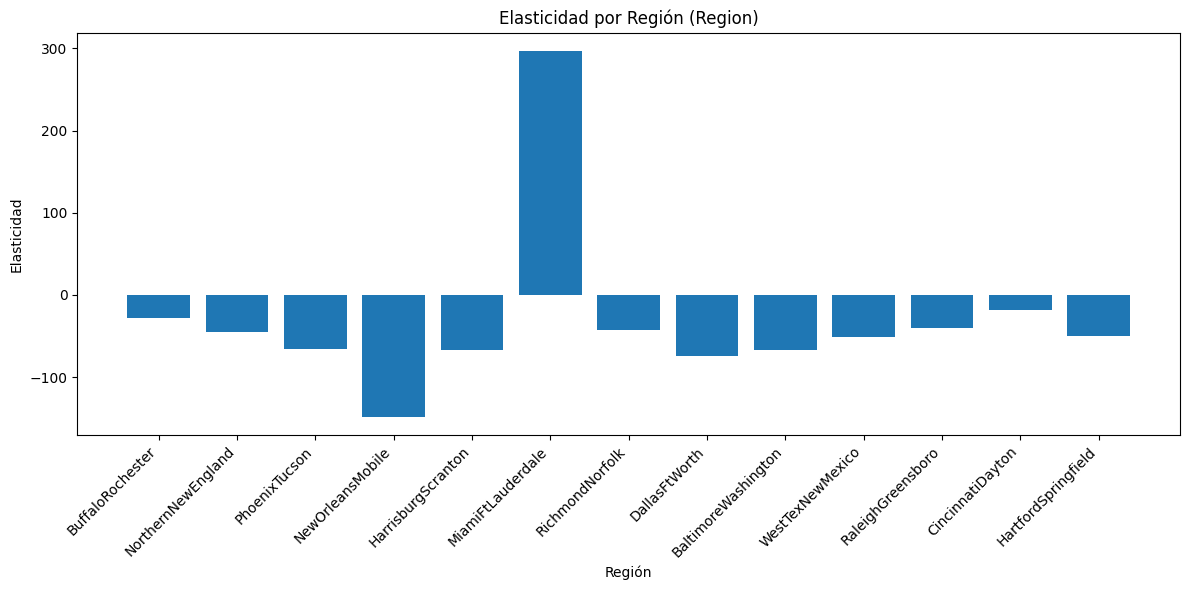

In [3]:
"""
3.2 Comparación de Elasticidad en Diferentes Mercados:

Uso de Datos: Utiliza las columnas Total Volume y AveragePrice.
Esperado: Calcula la elasticidad del precio de la demanda en diferentes regiones.
Agrupa los datos por region y calcula la elasticidad para cada región utilizando pd.pct_change().
Presenta un gráfico de barras que muestre la elasticidad por región usando plt.bar().
"""
# 3.2 Comparación de Elasticidad en Diferentes Mercados:
import matplotlib.pyplot as plt
import numpy as np

dfs = [df_reduced, df_cities, df_regions]
labels = ['GreaterRegion', 'City', 'Region']

for df, label in zip(dfs, labels):
    # Agrupar por region y calcular elasticidad
    elasticities = {}
    for region in df['region'].unique():
        df_region = df[df['region'] == region].copy()  
        
        # Calcular porcentaje de cambio usando .loc
        df_region.loc[:, 'Price_pct_change'] = df_region['AveragePrice'].pct_change()
        df_region.loc[:, 'Volume_pct_change'] = df_region['Total Volume'].pct_change()
        df_region.loc[:, 'Elasticity'] = df_region['Volume_pct_change'] / df_region['Price_pct_change']

        # quitar inifinitos y NaN
        df_region.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_region.dropna(subset=['Elasticity'], inplace=True)

        # Calcular elasticidad para la region
        elasticities[region] = df_region['Elasticity'].mean()

    # dibujar
    plt.figure(figsize=(12, 6))  # fijar taaño del gráfico
    plt.bar(elasticities.keys(), elasticities.values())
    plt.title(f'Elasticidad por Región ({label})')
    plt.xlabel('Región')
    plt.ylabel('Elasticidad')
    plt.xticks(rotation=45, ha='right')  # mejorar legibilidad
    plt.tight_layout()  # ajustar tamaños para evitar solape
    plt.show()
    print("===============================================================================================")
    print("===============================================================================================")

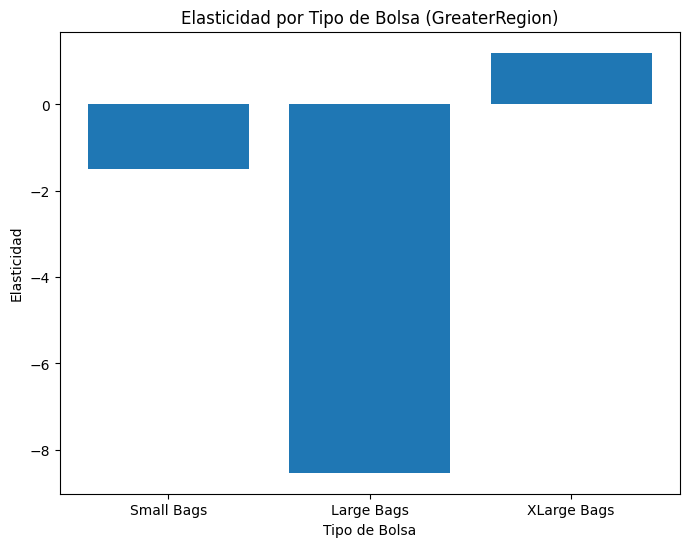

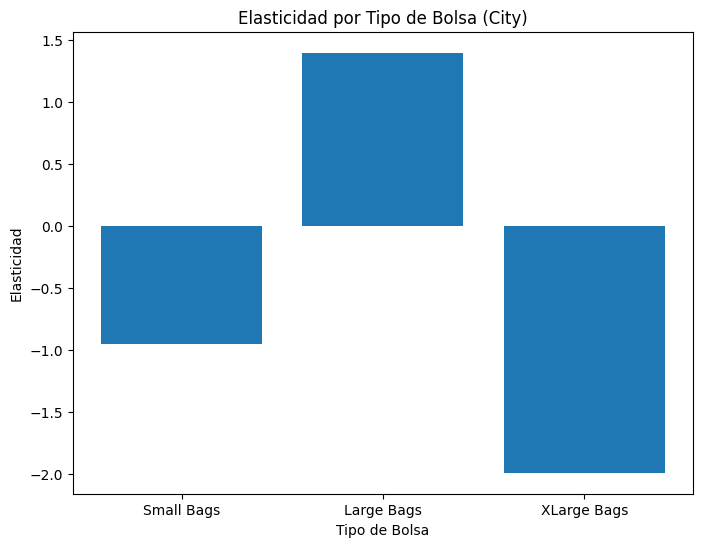

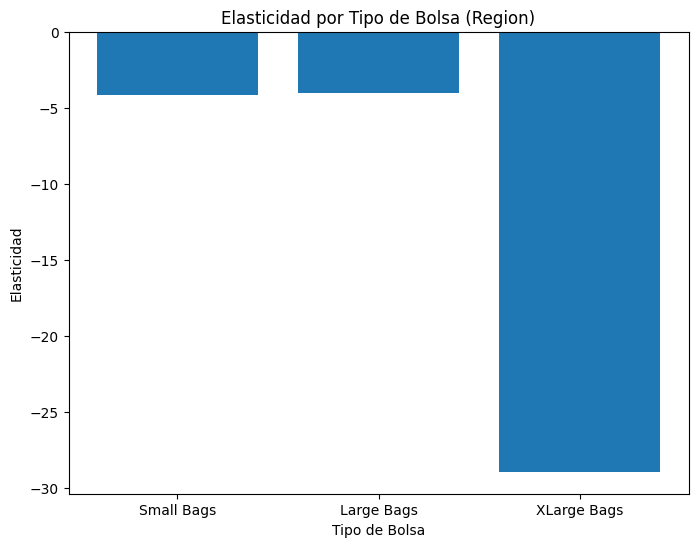

In [4]:
"""
3.3 Elasticidad a Nivel de Tipo de Bolsa:

Uso de Datos: Usa las columnas AveragePrice y Total Bags.
Esperado: Calcula la elasticidad del precio de la demanda específica para cada tipo de bolsa.
Suma los volúmenes de ventas por tipo de bolsa utilizando groupby() y sum().
Calcula la elasticidad para cada tipo y presenta los resultados en un gráfico comparativo usando plt.bar()
"""
# DEfinir tipos de bolsas y region_type
bag_types = ['Small Bags', 'Large Bags', 'XLarge Bags']
dfs = [df_reduced, df_cities, df_regions]
labels = ['GreaterRegion', 'City', 'Region']

for df, label in zip(dfs, labels):
    # agrupar por fecha y sumar por AveragePrice
    df_bags = df.groupby('Date')[bag_types + ["AveragePrice"]].sum().reset_index()
#    df_bags['AveragePrice'] = df['AveragePrice'].values  # añadir columna AveragePrice

    # Calcular elasticidad por tipo de bolsa
    elasticities = {}
    for bag_type in bag_types:
        df_bags['Price_pct_change'] = df_bags['AveragePrice'].pct_change()
        df_bags['Volume_pct_change'] = df_bags[bag_type].pct_change()
        df_bags['Elasticity'] = df_bags['Volume_pct_change'] / df_bags['Price_pct_change']

        # quitar infinitos y NaNs
        df_bags.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_bags.dropna(subset=['Elasticity'], inplace=True)

        # Cacular elasticidad media
        elasticities[bag_type] = df_bags['Elasticity'].mean()
    
    # dibujar
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    plt.bar(elasticities.keys(), elasticities.values())
    plt.title(f'Elasticidad por Tipo de Bolsa ({label})')
    plt.xlabel('Tipo de Bolsa')
    plt.ylabel('Elasticidad')
    plt.show()
    print("===============================================================================================")
    print("===============================================================================================")

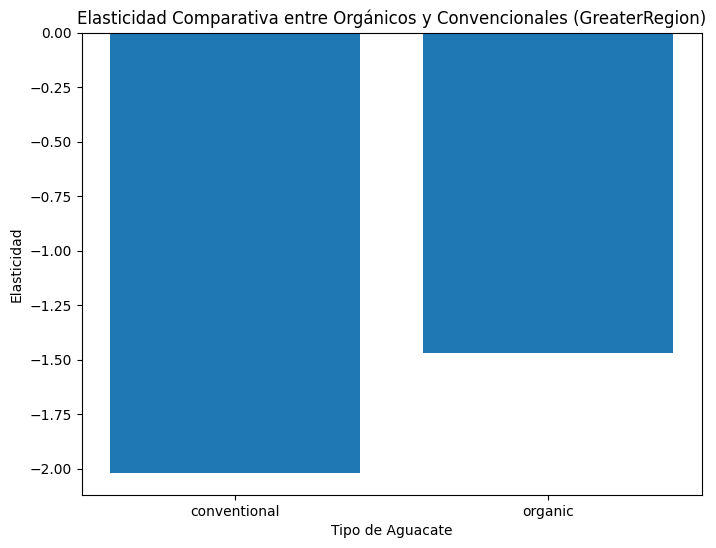

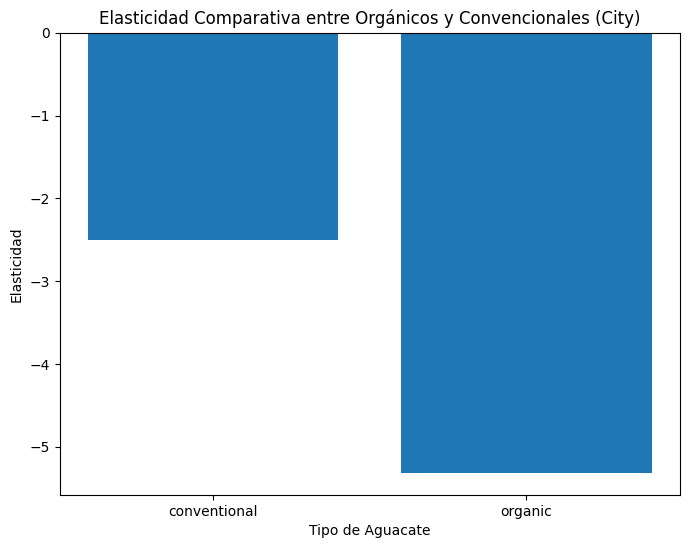

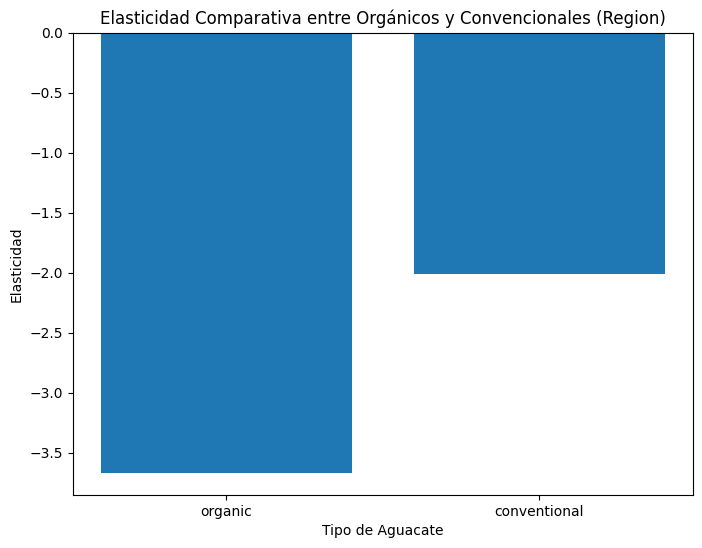

In [5]:
"""
3.4 Análisis de Elasticidad Comparativa entre Orgánicos y Convencionales:

Uso de Datos: Usa las columnas AveragePrice, Total Volume y type.
Esperado: Compara la elasticidad de la demanda entre aguacates orgánicos y convencionales.
Agrupa los datos por type y calcula la elasticidad utilizando pd.pct_change().
Presenta un gráfico que muestre la diferencia en elasticidad entre los dos tipos usando plt.bar().
"""
# 3.4 Análisis de Elasticidad Comparativa entre Orgánicos y Convencionales
import matplotlib.pyplot as plt
import numpy as np

dfs = [df_reduced, df_cities, df_regions]
labels = ['GreaterRegion', 'City', 'Region']

for df, label in zip(dfs, labels):
    # Agrupar por type y cacular elasticidad
    elasticities = {}
    for avocado_type in df['type'].unique():
        # Crear una copia
        df_type = df[df['type'] == avocado_type].copy() 
        
        # Calcular porcetage usando .loc
        df_type.loc[:, 'Price_pct_change'] = df_type['AveragePrice'].pct_change()
        df_type.loc[:, 'Volume_pct_change'] = df_type['Total Volume'].pct_change()
        df_type.loc[:, 'Elasticity'] = df_type['Volume_pct_change'] / df_type['Price_pct_change']

        # elminar ceros, infinitos y NaN
        df_type.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_type.dropna(subset=['Elasticity'], inplace=True)

        # calcular elasticidad media
        elasticities[avocado_type] = df_type['Elasticity'].mean()

    # dibujar
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    plt.bar(elasticities.keys(), elasticities.values())
    plt.title(f'Elasticidad Comparativa entre Orgánicos y Convencionales ({label})')
    plt.xlabel('Tipo de Aguacate')
    plt.ylabel('Elasticidad')
    plt.show()
    print("===============================================================================================")
    print("===============================================================================================")

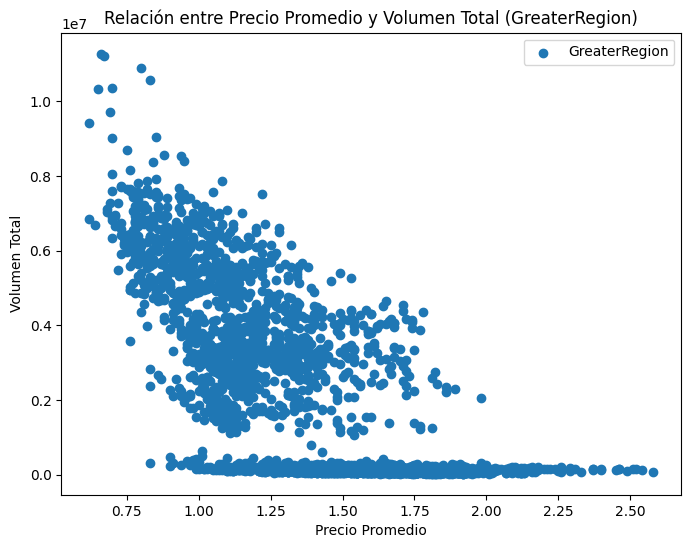

Observaciones para GreaterRegion: 
 Relación inversa entre volumen y precio: a menor precio, mayor volumen total


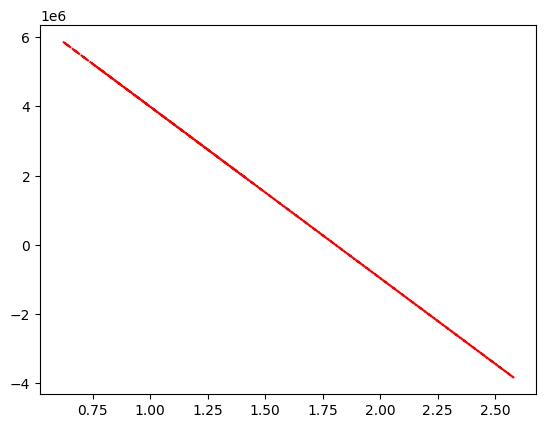

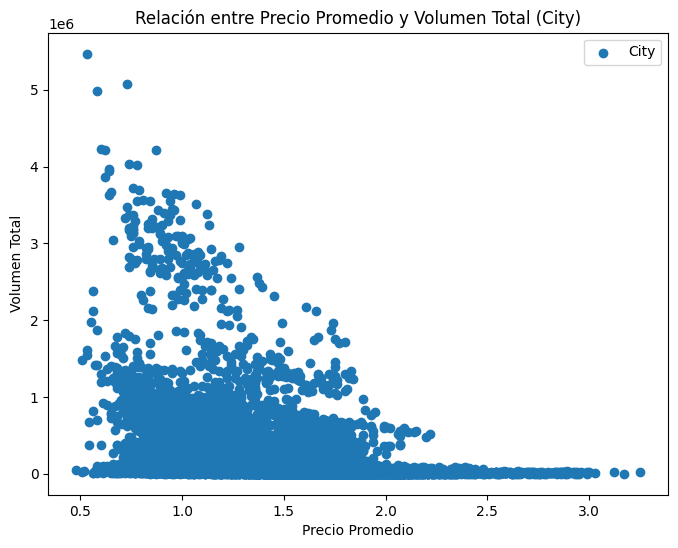

Observaciones para City: 
 Relación inversa entre volumen y precio: a menor precio, mayor volumen total


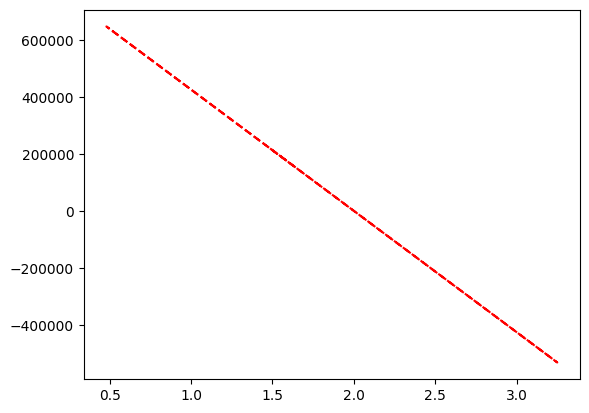

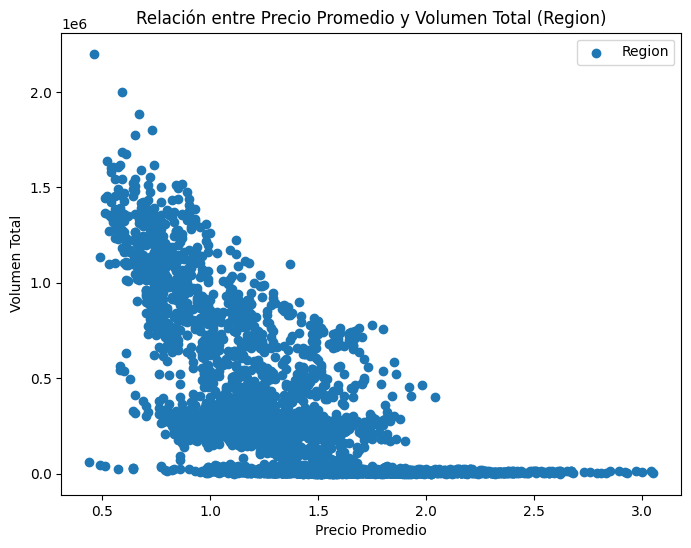

Observaciones para Region: 
 Relación inversa entre volumen y precio: a menor precio, mayor volumen total


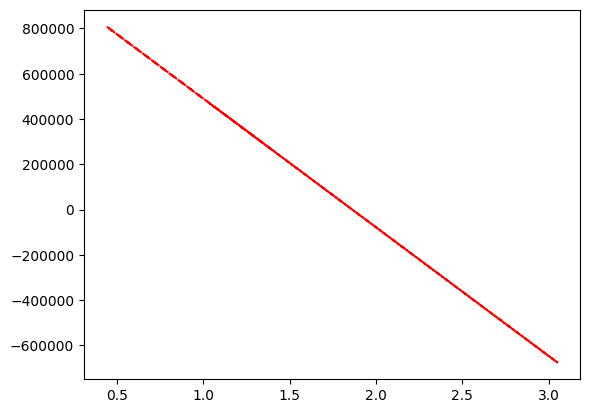

In [6]:
"""
3.5 Análisis de la Elasticidad Precios-Ventas:

Uso de Datos: Usa las columnas AveragePrice y Total Volume.
Esperado: Examina cómo las variaciones en AveragePrice afectan a Total Volume.
Realiza un análisis de la relación entre estas dos variables calculando la elasticidad.
Presenta un gráfico de dispersión que muestre la relación y discute la tendencia observada utilizando plt.scatter() y plt.plot()
"""
# 3.5 Análisis de la Elasticidad Precios-Ventas
import matplotlib.pyplot as plt
import numpy as np

dfs = [df_reduced, df_cities, df_regions]
labels = ['GreaterRegion', 'City', 'Region']

for df, label in zip(dfs, labels):
    # Calcular porcentaje de cambio y elasticidad
    df['Price_pct_change'] = df['AveragePrice'].pct_change()
    df['Volume_pct_change'] = df['Total Volume'].pct_change()
    df['Elasticity'] = df['Volume_pct_change'] / df['Price_pct_change']

    # Remove infinite and NaN values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['Elasticity'], inplace=True)

    # crear gráfico de dispersion
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    plt.scatter(df['AveragePrice'], df['Total Volume'], label=label) 
    plt.title(f'Relación entre Precio Promedio y Volumen Total ({label})')
    plt.xlabel('Precio Promedio')
    plt.ylabel('Volumen Total')
    plt.legend()
    plt.show()

    # Optionally, add a trend line
    # You might need to import numpy as np if not already imported
    z = np.polyfit(df['AveragePrice'], df['Total Volume'], 1)
    p = np.poly1d(z)
    plt.plot(df['AveragePrice'], p(df['AveragePrice']), "r--")  # Plot trend line

    # Discuss the observed trend (add your observations here)
    print(f"Observaciones para {label}: \n Relación inversa entre volumen y precio: a menor precio, mayor volumen total")
    # ... (your observations based on the scatter plot) ...
    print("===============================================================================================")
    print("===============================================================================================")